In [244]:
import os 
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from tqdm import tqdm
from botorch.acquisition.active_learning import (
    MCSampler,
    qNegIntegratedPosteriorVariance,
)
from botorch.utils.sampling import draw_sobol_samples
import seaborn as sns
from botorch.fit import fit_gpytorch_mll
from sklearn.model_selection import train_test_split
from botorch.models.gp_regression import SingleTaskGP
from sklearn.metrics import mean_absolute_error
from gpytorch.mlls import ExactMarginalLogLikelihood
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from botorch.utils.transforms import normalize, standardize

from botorch.exceptions.warnings import BotorchTensorDimensionWarning, InputDataWarning
warnings.filterwarnings(
            "ignore",
            message="Input data is not standardized.",
            category=InputDataWarning,
        )
import random
import warnings
warnings.filterwarnings("ignore")

In [171]:
os.getcwd()

'/Users/ramseyissa/Documents/GitHub/qNIPV/notebooks'

In [172]:
df = pd.read_csv('../datasets/citrine_thermal_conductivity.csv')
df

,formula,k_expt,k-units,k_condition,k_condition_units
0,BeS,157.0,W/m.K,room temperature,"[{'name': 'Temperature', 'scalars': [{'value':..."
1,CdS,19.9,W/m.K,room temperature,"[{'name': 'Temperature', 'scalars': [{'value':..."
2,GaN,181.0,W/m.K,room temperature,"[{'name': 'Temperature', 'scalars': [{'value':..."
3,ZnO,64.5,W/m.K,room temperature,"[{'name': 'Temperature', 'scalars': [{'value':..."
4,ZnSe,15.6,W/m.K,room temperature,"[{'name': 'Temperature', 'scalars': [{'value':..."
...,...,...,...,...,...
867,SiC,40.0,Wm$^{-1}$K$^{-1}$,1773,K
868,Al2O3,6.0,Wm$^{-1}$K$^{-1}$,1773,K
869,ZrO2,2.4,Wm$^{-1}$K$^{-1}$,1773,K
870,ThO2,2.0,Wm$^{-1}$K$^{-1}$,1773,K


In [6]:
df.head()
df.value_counts()

formula            k_expt    k-units            k_condition       k_condition_units                                                    
Sr0.61Ba0.39Nb2O6  1.6670    W/m$\cdot$K        300               K                                                                        3
TiO2               0.3800    W\m K              Room temperature  [{'name': 'Temperature', 'scalars': [{'value': 'Room temperature'}]}]    3
CuBr               2.7500    W/m.K              room temperature  [{'name': 'Temperature', 'scalars': [{'value': 'room temperature'}]}]    2
GaN                181.0000  W/m.K              room temperature  [{'name': 'Temperature', 'scalars': [{'value': 'room temperature'}]}]    2
BeO                447.0000  W/m.K              room temperature  [{'name': 'Temperature', 'scalars': [{'value': 'room temperature'}]}]    2
                                                                                                                                          ..
CuCr0.97Mg0.03O2  

In [173]:
for val in df['k_condition'].values:
    if val == 'room temperature':
        df['k_condition'] = df['k_condition'].replace(val, 300)
    elif val == 'Standard':
        df['k_condition'] = df['k_condition'].replace(val, 300)
    elif val == 'Room temperature':
        df['k_condition'] = df['k_condition'].replace(val, 300)
    else:
        pass

    

In [174]:
df['k_condition'].value_counts()

k_condition
300     204
400     187
700     183
1000    129
300      72
773      25
373      24
298      19
1273     19
1773     10
Name: count, dtype: int64

In [15]:
df['k_condition'].value_counts()

k_condition
300     204
400     187
700     183
1000    129
300      72
773      25
373      24
298      19
1273     19
1773     10
Name: count, dtype: int64

In [17]:
df.columns

Index(['formula', 'k_expt', 'k-units', 'k_condition', 'k_condition_units'], dtype='object')

In [175]:
df.head()
df.drop(columns=['k-units','k_condition_units'],inplace=True)
df.head()

,formula,k_expt,k_condition
0,BeS,157.0,300
1,CdS,19.9,300
2,GaN,181.0,300
3,ZnO,64.5,300
4,ZnSe,15.6,300


In [176]:
x = 0
for indx,row in df.iterrows():
    if row['k_condition'] == 300 or row['k_condition'] == 298:
        x += 1
print(x)
        
# convert the k_condition column to float
df['k_condition'] = df['k_condition'].astype(float)



72


In [177]:
df['k_condition'].value_counts()

#create mask for certain values in the k_condition column
mask = (df['k_condition'] == 300.0) | (df['k_condition'] == 298.0)
df_mask = df[mask]
df_mask


,formula,k_expt,k_condition
0,BeS,157.0,300.0
1,CdS,19.9,300.0
2,GaN,181.0,300.0
3,ZnO,64.5,300.0
4,ZnSe,15.6,300.0
...,...,...,...
796,SiO2,11.0,298.0
797,Al2O3,38.0,298.0
798,ZrO2,1.8,298.0
799,ThO2,14.0,298.0


In [178]:
df_mask.reset_index(drop=True,inplace=True)
df_mask

,formula,k_expt,k_condition
0,BeS,157.0,300.0
1,CdS,19.9,300.0
2,GaN,181.0,300.0
3,ZnO,64.5,300.0
4,ZnSe,15.6,300.0
...,...,...,...
290,SiO2,11.0,298.0
291,Al2O3,38.0,298.0
292,ZrO2,1.8,298.0
293,ThO2,14.0,298.0


In [179]:
df_mask.drop(columns=['k_condition'],inplace=True)
df_mask

,formula,k_expt
0,BeS,157.0
1,CdS,19.9
2,GaN,181.0
3,ZnO,64.5
4,ZnSe,15.6
...,...,...
290,SiO2,11.0
291,Al2O3,38.0
292,ZrO2,1.8
293,ThO2,14.0


In [180]:
for vals in df_mask['formula'].value_counts().index:
    if df_mask['formula'].value_counts()[vals] > 1:
        mask_df = df_mask.loc[df_mask['formula'] == vals]
        mean_val = mask_df['k_expt'].mean()
        
        print(vals,mean_val)
        #replace the k_expt values with the mean value
        df_mask.loc[df_mask['formula'] == vals, 'k_expt'] = mean_val
        #drop the duplicate rows
        
        
    

TiO2 0.7622727272727272
Ba8Ga16Ge30 1.79
Zn4Sb3 0.8307499999999999
SiC 284.6666666666667
SiO2 6.366666666666667
Bi2Te3 2.4949707406666666
AlN 168.66666666666666
Sb2Te3 3.1110078933333334
Sr0.61Ba0.39Nb2O6 1.667
CaMnO3 7.5938799999999995
BeO 398.0
ZnO 59.23333333333333
NaCo2O4 10.491999999999999
Tl2SnTe5 5.92
CeFe3CoSb12 1.6400000000000001
TiNiSn 6.89805
Zr0.5Hf0.5NiSn 4.0179779035
Yb14MnSb11 0.97
Mg2Si 5.875
CeFe4Sb12 8.275
CdS 19.9
Ca3Co4O9 2.755
AgI 2.44
CuI 7.1
GaN 181.0
CuBr 2.75
SrTi0.8Nb0.2O3 9.19
In0.2Co4Sb12 2.5231199999999996
CuCl 1.26


In [181]:
df_mask.drop_duplicates(subset=['formula'],inplace=True)
df_mask

,formula,k_expt
0,BeS,157.000000
1,CdS,19.900000
2,GaN,181.000000
3,ZnO,59.233333
4,ZnSe,15.600000
...,...,...
287,Si,150.000000
291,Al2O3,38.000000
292,ZrO2,1.800000
293,ThO2,14.000000


In [182]:
df_mask['target'] = df_mask['k_expt']   
df_mask

,formula,k_expt,target
0,BeS,157.000000,157.000000
1,CdS,19.900000,19.900000
2,GaN,181.000000,181.000000
3,ZnO,59.233333,59.233333
4,ZnSe,15.600000,15.600000
...,...,...,...
287,Si,150.000000,150.000000
291,Al2O3,38.000000,38.000000
292,ZrO2,1.800000,1.800000
293,ThO2,14.000000,14.000000


In [183]:
df_mask.drop(columns=['k_expt'],inplace=True)

### dataset cleaned

In [184]:
from CBFV import composition
X, y, formulae, skipped = composition.generate_features(df_mask)
X 

Processing Input Data: 100%|██████████| 233/233 [00:00<00:00, 9622.52it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 233/233 [00:00<00:00, 2345.69it/s]

	Creating Pandas Objects...


,avg_Atomic_Number,avg_Atomic_Weight,avg_Period,avg_group,avg_families,avg_Metal,avg_Nonmetal,avg_Metalliod,avg_Mendeleev_Number,avg_l_quantum_number,...,mode_polarizability(A^3),mode_Melting_point_(K),mode_Boiling_Point_(K),mode_Density_(g/mL),mode_specific_heat_(J/g_K)_,mode_heat_of_fusion_(kJ/mol)_,mode_heat_of_vaporization_(kJ/mol)_,mode_thermal_conductivity_(W/(m_K))_,mode_heat_atomization(kJ/mol),mode_Cohesive_energy
0,10.000000,20.539090,2.500000,9.000000,4.500000,0.500000,0.500000,0.0,77.500000,0.500000,...,2.900,385.95,717.85,1.85000,0.71,1.71750,9.8000,0.26900,279.0,2.85
1,32.000000,72.238500,4.000000,14.000000,5.500000,0.500000,0.500000,0.0,79.000000,0.500000,...,2.900,385.95,717.85,2.07000,0.23,1.71750,9.8000,0.26900,112.0,1.16
2,19.000000,41.864870,3.000000,14.000000,6.000000,0.500000,0.500000,0.0,78.000000,1.000000,...,1.100,63.25,77.35,0.00125,0.37,0.36040,2.7928,0.02598,286.0,2.81
3,19.000000,40.694700,3.000000,14.000000,5.500000,0.500000,0.500000,0.0,78.000000,1.500000,...,0.793,54.75,90.15,0.00143,0.39,0.22259,3.4099,0.02674,131.0,1.35
4,32.000000,72.175000,4.000000,14.000000,5.500000,0.500000,0.500000,0.0,79.000000,1.500000,...,3.800,490.15,958.15,4.79000,0.32,6.69400,37.7000,0.52000,131.0,1.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,14.000000,28.085500,3.000000,14.000000,6.000000,0.000000,1.000000,0.0,78.000000,1.000000,...,5.400,1683.15,2628.15,2.33000,0.71,50.55000,384.2200,148.00000,452.0,4.63
229,10.000000,20.392256,2.400000,14.800000,6.200000,0.400000,0.600000,0.0,81.400000,1.000000,...,0.793,54.75,90.15,0.00143,0.92,0.22259,3.4099,0.02674,249.0,2.62
230,18.666667,41.074267,3.000000,12.000000,6.000000,0.333333,0.666667,0.0,72.666667,1.333333,...,0.793,54.75,90.15,0.00143,0.92,0.22259,3.4099,0.02674,249.0,2.62
231,35.333333,88.012300,3.666667,11.666667,5.666667,0.333333,0.666667,0.0,63.333333,1.333333,...,0.793,54.75,90.15,0.00143,0.92,0.22259,3.4099,0.02674,249.0,2.62


In [185]:
X = X.drop(['max_Number_of_unfilled_f_valence_electrons','min_valence_f'], axis=1)
y_df = y.to_frame(name='k_expt')

In [194]:
min_bounds = X.min().to_numpy()
max_bounds = X.max().to_numpy()

In [195]:
minx_bounds = torch.tensor(min_bounds, dtype=torch.double)
maxx_bounds = torch.tensor(max_bounds, dtype=torch.double)

xbounds = torch.stack([minx_bounds, maxx_bounds])
xbounds


tensor([[5.2000e+00, 1.1051e+01, 2.0000e+00, 5.9800e+00, 3.3200e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 4.2333e+01, 3.2667e-01, 6.7000e-01, 7.7000e+01,
         7.7000e-01, 6.4000e-01, 7.0000e-01, 2.5800e-01, 1.4963e+00, 1.5273e+00,
         3.3758e+00, 3.4829e+00, 1.4920e+00, 8.8800e-01, 2.6667e+00, 1.5000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.4000e+00,
         0.0000e+00, 5.2500e+00, 1.0000e+00, 6.6263e+02, 1.8000e+00, 1.8310e+02,
         6.3465e+02, 7.7762e-01, 1.5563e-01, 1.4388e+00, 4.8543e+01, 4.5580e+00,
         1.5450e+02, 1.6750e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e

### normalize and standardize the data and split data into training and testing sets

In [197]:
X = normalize(X, bounds=xbounds)

ydf_tens = torch.tensor(y_df.values,dtype=torch.double)
y = standardize(ydf_tens)



In [209]:
X.shape

(233, 262)

In [210]:
y.shape

torch.Size([233, 1])

In [211]:
# ydf = pd.DataFrame(y.numpy(), columns=['target'])
# ydf

xcandidates_set, xtest, ycandidates_set, ytest = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
dtype = torch.double
xtest = torch.tensor(xtest.values,dtype=dtype)
ytest = torch.tensor(ytest,dtype=dtype)

In [225]:
xcandidates_original = torch.tensor(xcandidates_set.values, dtype=dtype)
ycandidates_original = ycandidates_set.clone()
# ycandidates_original = torch.tensor(ycandidates_set.values, dtype=dtype)

In [228]:
def random_initial_data(x, y, initial_percent, seed=None):
    if seed is not None:  # Check if a seed is provided
        np.random.seed(seed)
    # np.random.seed(seed)
    n = int(x.shape[0]*initial_percent)
    idx = np.random.choice(x.shape[0], n, replace=False)
    x_initial = x[idx]
    y_initial = y[idx]
    x_candidates = np.delete(x, idx, axis=0)
    y_candidates = np.delete(y, idx, axis=0)
    return x_initial, y_initial, x_candidates, y_candidates

In [ ]:
minx_bounds = torch.tensor(xcandidates_set.min(axis=0), dtype=torch.double)
maxx_bounds = torch.tensor(xcandidates_set.max(axis=0), dtype=torch.double)

In [ ]:
bounds = torch.stack([minx_bounds, maxx_bounds])
bounds

In [229]:
seeds = [np.random.randint(1, 10000) for i in range(25)]

In [241]:
mcp = draw_sobol_samples(bounds=bounds, n=1024, q=1, seed=42).squeeze(1)
mcp.shape

torch.Size([1024, 262])

In [263]:
xcandidates = xcandidates_original.clone()
ycandidates = ycandidates_original.clone()

gp = SingleTaskGP(xcandidates, ycandidates) 
    # gp = SingleTaskGP(xinit, ytrain_,covar_module=rbf_kernel)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll)
#predict the y values for the test set
ypred = gp(xtest)
ypred_mean = ypred.mean.detach().numpy()
# pred_y.append(ypred_mean)

#calculate the mean absolute error and the standard deviation for the test set
ymae = mean_absolute_error(ytest, ypred_mean)
ymae

0.11377160576616563

### qNIPV

In [ ]:

# def qnipv_runs() -> list:

rand_selection_mae = []
xmax_candidates = []
pred_mae = []
pred_y = []
pred_std = []
qnipv_runs =[]

def find_max_normalized_acqval(tensor_list, qNIVP):
    max_value = None
    max_index = -1
    acq_val_lst = []
    # torch.manual_seed(13)
    for i, tensor_ in enumerate(tensor_list):
        tensor = tensor_.unsqueeze(0)
        qNIVP_val = qNIVP(tensor)
        acq_val_lst.append(qNIVP_val.item())  # Assuming it's a scalar tensor

        # Check if this is the maximum value so far
        if max_value is None or qNIVP_val > max_value:
            max_value = qNIVP_val
            max_index = i

    return max_value, max_index, acq_val_lst

for i in tqdm(seeds):
    xcandidates = xcandidates_original.clone()
    ycandidates = ycandidates_original.clone()
    xinit, yinit, xcandidates, ycandidates = random_initial_data(xcandidates, ycandidates, 0.05, seed=i)
    
    print('len of initial train:', len(xinit))
    
    gp = SingleTaskGP(xinit, yinit)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    posterior = gp(xtest)
    ypred = posterior.mean.detach().numpy()
    ystd = posterior.stddev.detach().numpy()
    
    
    # pred_y.append(ypred_mean)
    ymae = mean_absolute_error(ytest, ypred)
    
    pred_mae = []
    pred_y.append(ypred)
    pred_std.append(ystd)
    pred_mae.append(ymae)

    for inner_i in tqdm(range(len(xcandidates))):
        if not len(xcandidates):
            break
        
        qNIVP = qNegIntegratedPosteriorVariance(gp, mc_points= mcp)
        
        
        max_value, max_index, acq_val_lst = find_max_normalized_acqval(xcandidates, qNIVP)
        xmax_candidates.append(max_index)
        
        
        xinit= torch.cat((xinit, xcandidates[max_index].unsqueeze(0)), 0)
        yinit = torch.cat((yinit, ycandidates[max_index].unsqueeze(0)), 0)
        
        print('len of new train:', len(xinit))
            
        xcandidates = torch.cat((xcandidates[:max_index], xcandidates[max_index + 1:]))
        ycandidates = torch.cat((ycandidates[:max_index], ycandidates[max_index + 1:]))
        
        print('len of new candidates:', len(xcandidates))
        
        gp = SingleTaskGP(xinit, yinit) 
        # gp = SingleTaskGP(xinit, ytrain_,covar_module=rbf_kernel)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        #predict the y values for the test set
        ypred = gp(xtest)
        ypred_mean = ypred.mean.detach().numpy()
        pred_y.append(ypred_mean)

        #calculate the mean absolute error and the standard deviation for the test set
        ymae = mean_absolute_error(ytest, ypred_mean)
        # print('mean absolute error: ', ymae)
        pred_mae.append(ymae)
        ystd = gp(xtest).stddev
        ystd = ystd.detach().numpy()
        pred_std.append(ystd)
    qnipv_runs.append(pred_mae)
# return qnipv_runs, gp

In [248]:
os.getcwd()

'/Users/ramseyissa/Documents/GitHub/qNIPV/notebooks'

In [252]:
# Convert to numpy array and save as .npy file
np.save('thermo_qnipv.npy', np.array(qnipv_runs))

# Load the .npy file and convert back to list of lists
loaded_list_of_lists = np.load('thermo_qnipv.npy', allow_pickle=True).tolist()


25

### random runs

###

In [247]:
# def random_runs() -> list:

xcandidates_rand = xcandidates_original.clone()
ycandidates_rand = ycandidates_original.clone()

rand_xmax_candidates = []
rand_pred_mae = []
rand_pred_std = []
rand_pred_mean = []

# rbf_kernel = kernels.RBFKernel()

# combined_kernel = periodic_kernel * rbf_kernel
random_mae_seeds =[]

# gp = SingleTaskGP(xinit, ytrain_,covar_module=rbf_kernel)
# random_seeds = [0,13,90,14,12]
for i in tqdm(seeds):
    # random.seed(seed)
    # xcandidates_rand = x_candidates.clone()
    # ycandidates_rand = y_candidates.clone()
    xcandidates_rand = xcandidates_original.clone()
    ycandidates_rand = ycandidates_original.clone()
    xinit_rand, yinit_rand, xcandidates_rand, ycandidates_rand = random_initial_data(xcandidates_rand, ycandidates_rand, 0.05, seed=i)
    # print(f'length of xinit:',len(xinit_rand))
    # print(f'length of xcandidates:',len(xcandidates_rand))
    
    # xinit_rand = x_init.clone()
    # yinit_rand = y_init.clone()
    
    rand_xmax_candidates = []
    rand_pred_mae = []
    rand_pred_std = []
    rand_pred_mean = []

    gp = SingleTaskGP(xinit_rand, yinit_rand) 
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    #predict the y values for the test set
    rand_ypred = gp(xtest)
    rand_ypred_mean = rand_ypred.mean.detach().numpy()
    rand_pred_mean.append(rand_ypred_mean)
    #calculate the mean absolute error and the standard deviation for the test set
    rand_ymae = mean_absolute_error(ytest, rand_ypred_mean)
    # print('mean absolute error: ', rand_ymae)
    rand_pred_mae.append(rand_ymae)
        
    rand_ystd = gp(xtest).stddev
    ystd_ = rand_ystd.detach().numpy()
    rand_pred_std.append(ystd_)
    # print("initial len of xinit", len(xinit_rand))
    
    
    
    for inner_i in tqdm(range(len(xcandidates_rand))):
        if not len(xcandidates_rand):
            break
        
        rand_select = random.randint(0, len(xcandidates_rand) - 1)
        
        # Add the selected tensor to the training sets
        xinit_rand = torch.cat((xinit_rand, xcandidates_rand[rand_select].unsqueeze(0)), 0)
        yinit_rand = torch.cat((yinit_rand, ycandidates_rand[rand_select].unsqueeze(0)), 0)
        
        # Print the length of new training set
        # print('len of new train:', len(xinit_rand))

        # Remove the selected tensor from xcandidates and ycandidates
        xcandidates_rand = torch.cat((xcandidates_rand[:rand_select], xcandidates_rand[rand_select + 1:]))
        ycandidates_rand = torch.cat((ycandidates_rand[:rand_select], ycandidates_rand[rand_select + 1:]))
        
        # Update GP model, fit and predict
        gp = SingleTaskGP(xinit_rand, yinit_rand) 
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        
        # Predict the y values for the test set and calculate errors
        rand_ypred = gp(xtest)
        rand_ypred_mean = rand_ypred.mean.detach().numpy()
        rand_pred_mean.append(rand_ypred_mean)
        
        rand_ymae = mean_absolute_error(ytest, rand_ypred_mean)
        # print('mean absolute error: ', rand_ymae)
        rand_pred_mae.append(rand_ymae)
        
        rand_ystd = gp(xtest).stddev
        ystd_ = rand_ystd.detach().numpy()
        rand_pred_std.append(ystd_)
    random_mae_seeds.append(rand_pred_mae)
# return random_mae_seeds

100%|██████████| 25/25 [12:18<00:00, 29.52s/it]


In [253]:
np.save('thermo_random.npy', np.array(random_mae_seeds))

### QBC runs 

In [254]:

# def qbc_runs() -> list:
    # Your scikit-learn code here
gp_commit_lst = []
# Define a committee of regression models
committee = [
    RandomForestRegressor(),
    SVR(),
    DecisionTreeRegressor()
]

comit_pred_mae = []

commit_seeds = []
# pick the top 25 best samples 

for i in tqdm(seeds):
    
    xcandidates_comit = xcandidates_original.clone()
    ycandidates_comit = ycandidates_original.clone()
    xinit_comit, yinit_comit, xcandidates_comit, ycandidates_comit = random_initial_data(xcandidates_comit, ycandidates_comit, 0.05, seed=i)
    gp_commit_lst = []
    
    
    gp = SingleTaskGP(xinit_comit, yinit_comit)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    posterior = gp(xtest)
    ypred = posterior.mean.detach().numpy()
    
    # gp_commit_lst.append(ypred)
    comitt_ymae = mean_absolute_error(ytest, ypred)
    gp_commit_lst.append(comitt_ymae)
    for inner_i in tqdm(range(len(xcandidates_comit))):
        if not len(xcandidates_comit):
            print('empty')
            break
        # print(f'this is {i}')
        # fit all 3 models 
        for model in committee:
            # print(model)
            model.fit(xinit_comit, yinit_comit)

    # Make predictions on the unlabeled data for each model in the committee
        predictions = np.array([model.predict(xcandidates_comit) for model in committee])

    # Measure disagreement: calculate variance across the predictions of the committee for each data point
        disagreement_scores = np.var(predictions, axis=0)
        # print(f'disagreement_scores: {disagreement_scores}')

    # # Select the top N most uncertain points (highest disagreement)
        N = 1  # Number of points to query
        top_N_indices = np.argsort(disagreement_scores)[-N:]

    # # The selected data points to query for labels
        X_to_query = xcandidates_comit[top_N_indices]
        
        ylabel = ycandidates_comit[top_N_indices]
        
        xinit_comit = torch.cat((xinit_comit, X_to_query), 0)
        yinit_comit = torch.cat((yinit_comit, ylabel), 0)
        
        xcandidates_comit = torch.cat((xcandidates_comit[:int(top_N_indices)], xcandidates_comit[int(top_N_indices) + 1:]))
        # print(f'len of x candidates: {len(xcandidates_comit)}')
        ycandidates_comit = torch.cat((ycandidates_comit[:int(top_N_indices)], ycandidates_comit[int(top_N_indices) + 1:]))
        
        
        # for model in committee:
        #     model.fit(xinit_comit, yinit_comit)

        # # Make predictions on the test set
        # predictions = np.array([model.predict(xtest) for model in committee])
        # ypred_comit = np.mean(predictions, axis=0)
        # mae_comit = mean_absolute_error(ytest, ypred_comit)
        # # print(f'Mean Absolute Error: {mae_comit}')

        # comit_pred_mae.append(mae_comit)
        # ------------
        
        gp = SingleTaskGP(xinit_comit, yinit_comit)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        posterior = gp(xtest)
        ypred = posterior.mean.detach().numpy()
            
        comitt_ymae = mean_absolute_error(ytest, ypred)
        gp_commit_lst.append(comitt_ymae)
        # print(f'length of gp_commit_lst: {len(gp_commit_lst)}')
    commit_seeds.append(gp_commit_lst)
    
        
    # return commit_seeds 

100%|██████████| 25/25 [58:29<00:00, 140.39s/it]


In [256]:
np.save('thermo_committee.npy', np.array(commit_seeds))

### Uncertainty sampling runs

In [257]:

# def uncertainty_runs() -> list:
    # Setting random seeds
# torch.manual_seed(13)
# random.seed(1000)

# Initialize storage for results
uncr_xmax_candidates = []
uncr_pred_mae = []
uncr_pred_std = []
uncr_pred_mean = []
unc_rand_mae_seeds = []

# Random seeds for repeatability


for i in seeds:
    # random.seed(seed)
    
    
    xcandidates_uncr = xcandidates_original.clone()
    ycandidates_uncr = ycandidates_original.clone()
    xinit_uncr, yinit_uncr, xcandidates_uncr, ycandidates_uncr = random_initial_data(xcandidates_uncr, ycandidates_uncr, 0.05, seed=i)
    
    
    # Initialize lists to store intermediate results
    uncr_xmax_candidates = []
    uncr_pred_mae = []
    uncr_pred_std = []
    uncr_pred_mean = []

    # Train the initial GP model on the initial training set
    gp = SingleTaskGP(xinit_uncr, yinit_uncr)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    # Predict on the test set initially
    uncr_ypred = gp(xtest)
    uncr_ypred_mean = uncr_ypred.mean.detach().numpy()
    uncr_pred_mean.append(uncr_ypred_mean)
    
    # Calculate the initial mean absolute error (MAE) for the test set
    uncr_ymae = mean_absolute_error(ytest, uncr_ypred_mean)
    # print('Initial mean absolute error: ', uncr_ymae)
    uncr_pred_mae.append(uncr_ymae)
    
    # Calculate and store the initial standard deviation for the test set predictions
    uncr_ystd = gp(xtest).stddev.detach().numpy()
    uncr_pred_std.append(uncr_ystd)
    # print("Initial length of xinit", len(xinit_uncr))

    # Active learning loop (25 iterations)
    for inner_i in tqdm(range(len(xcandidates_uncr))):
        if not len(xcandidates_uncr):
            print('empty')
            break
        # Predict the uncertainty (posterior stddev) for all candidate points
        posterior_candidates = gp(xcandidates_uncr)
        uncertainties = posterior_candidates.stddev.detach().numpy()  # Extract the standard deviation (uncertainty)

        # Find the index of the candidate point with the highest uncertainty
        max_uncertainty_idx = uncertainties.argmax()

        # Add the selected candidate (with the highest uncertainty) to the training set
        xinit_uncr = torch.cat((xinit_uncr, xcandidates_uncr[max_uncertainty_idx].unsqueeze(0)), 0)
        yinit_uncr = torch.cat((yinit_uncr, ycandidates_uncr[max_uncertainty_idx].unsqueeze(0)), 0)

        # Print the length of the new training set
        # print('Length of new training set:', len(xinit_uncr))

        # Remove the selected candidate from the candidate set
        xcandidates_uncr = torch.cat((xcandidates_uncr[:max_uncertainty_idx], xcandidates_uncr[max_uncertainty_idx + 1:]))
        ycandidates_uncr = torch.cat((ycandidates_uncr[:max_uncertainty_idx], ycandidates_uncr[max_uncertainty_idx + 1:]))

        # Retrain the GP model on the updated training set
        gp = SingleTaskGP(xinit_uncr, yinit_uncr)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)

        # Predict the y values for the test set
        uncr_ypred = gp(xtest)
        uncr_ypred_mean = uncr_ypred.mean.detach().numpy()
        uncr_pred_mean.append(uncr_ypred_mean)

        # Calculate the mean absolute error (MAE) for the test set
        uncr_ymae = mean_absolute_error(ytest, uncr_ypred_mean)
        # print(f'Iteration {i}: mean absolute error = {uncr_ymae}')
        uncr_pred_mae.append(uncr_ymae)

        # Calculate and store the standard deviation (uncertainty) of the test set predictions
        uncr_ystd = gp(xtest).stddev.detach().numpy()
        uncr_pred_std.append(uncr_ystd)

    unc_rand_mae_seeds.append(uncr_pred_mae)
    # return unc_rand_mae_seeds

100%|██████████| 155/155 [00:17<00:00,  8.72it/s]


In [258]:
np.save('thermo_uncertainty.npy', np.array(unc_rand_mae_seeds))

In [259]:
len(xcandidates_original)

163

In [260]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
total_candidates = 163
initial_percent = 5  # Start with 5% of the dataset
num_iterations = 155  # Number of active learning iterations

# Calculate initial number of samples based on the initial percent
initial_samples = int(initial_percent / 100 * total_candidates)
x_percentages = [initial_percent]

# Calculate percentages for each iteration
for i in range(1, num_iterations + 1):
    percent = initial_percent + (i / total_candidates) * 100
    x_percentages.append(percent)


len(x_percentages)

156

In [ ]:
average_mae_commit = np.mean(commit_seeds, axis=0)
average_mae_rand = np.mean(random_mae_seeds, axis=0)
average_mae_qnipv = np.mean(qnipv_runs, axis=0)
average_mae_uncr = np.mean(unc_rand_mae_seeds, axis=0)

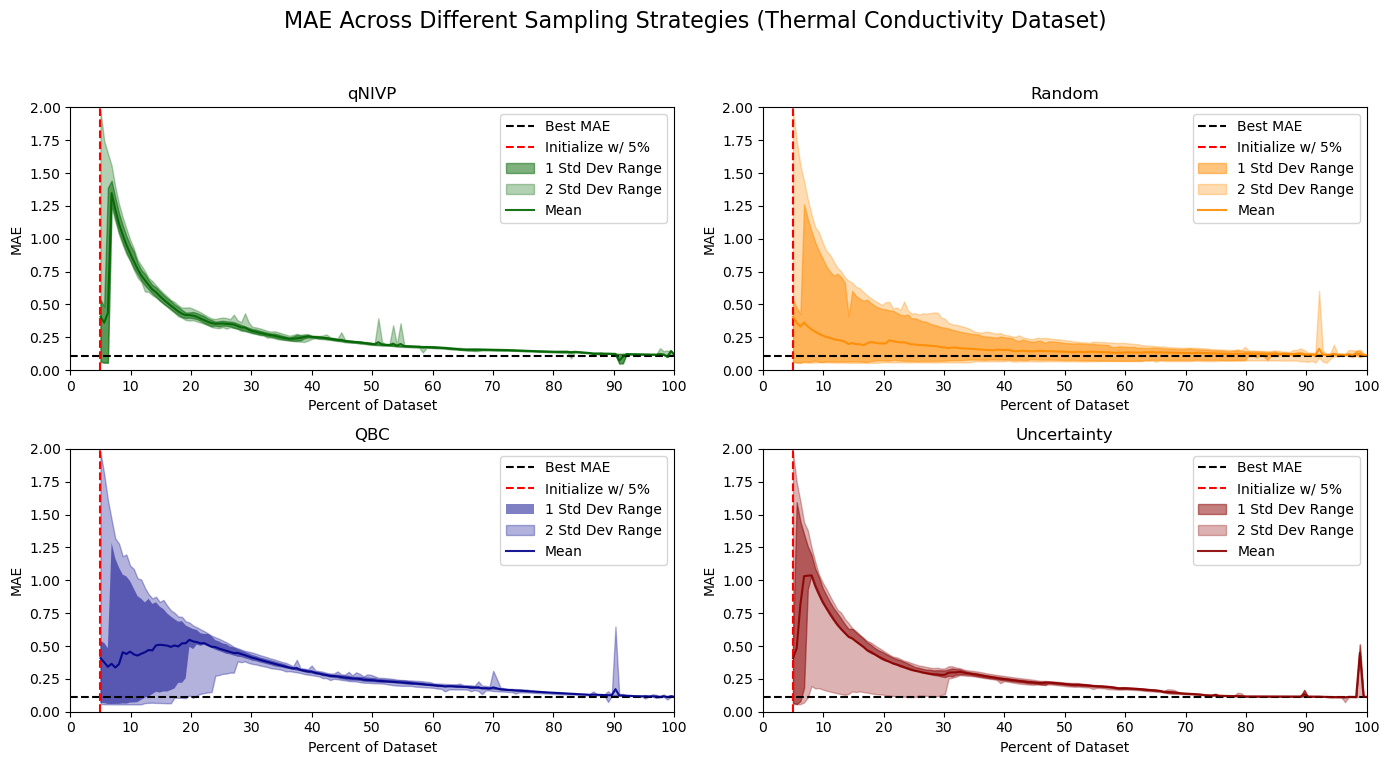

In [273]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('MAE Across Different Sampling Strategies (Thermal Conductivity Dataset)', fontsize=16)

# Plot a horizontal line at y=0.28 for all subplots
for ax in axs.flat:
    ax.axhline(y=0.11, color='k', linestyle='--', label='Best MAE')
    
for ax in axs.flat:
    ax.axvline(x=5, color='r', linestyle='--', label='Initialize w/ 5%')

#set the xlim and ylim for all subplots
for ax in axs.flat:
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 2])

#increment the xticks by 10
for ax in axs.flat:
    ax.set_xticks(np.arange(0, 101, 10))

# First subplot: qNIVP
axs[0, 0].fill_between(x_percentages, np.percentile(qnipv_runs,15.9,axis=0),np.percentile(qnipv_runs,84.1,axis=0) , ec='none',color='darkgreen', alpha=0.5, label='1 Std Dev Range')
axs[0, 0].fill_between(x_percentages,np.percentile(qnipv_runs,2.3,axis=0),np.percentile(qnipv_runs,97.7,axis=0) , ec='none',color='darkgreen', alpha=0.3, label='2 Std Dev Range')
axs[0, 0].plot(x_percentages, np.mean(qnipv_runs,axis=0), color='darkgreen',alpha=0.9, label='Mean')
# axs[0,0].plot(x_percentages, np.percentile(qnipv_runs[0],50,axis=0), color='darkgreen',alpha=0.5, label='Median')
# for mae_values in qnipv_runs[0]:
#     axs[0, 0].plot(x_percentages, mae_values, color='darkgreen', alpha=0.1)
axs[0, 0].set_title('qNIVP')
axs[0, 0].set_xlabel('Percent of Dataset')
axs[0, 0].set_ylabel('MAE')
axs[0, 0].legend()

# Second subplot: Random
axs[0, 1].fill_between(x_percentages,np.percentile(random_mae_seeds,15.9,axis=0),np.percentile(random_mae_seeds,84.1,axis=0), ec='none',color='darkorange', alpha=0.5, label='1 Std Dev Range')
axs[0, 1].fill_between(x_percentages, np.percentile(random_mae_seeds,2.3,axis=0),np.percentile(random_mae_seeds,97.7,axis=0), ec='none',color='darkorange', alpha=0.3, label='2 Std Dev Range')
axs[0,1].plot(x_percentages, np.mean(random_mae_seeds,axis=0), color='darkorange',alpha=0.9, label='Mean')
# axs[0,1].plot(x_percentages, np.percentile(random_runs,50,axis=0), color='darkorange',alpha=0.5, label='Mean')
# for mae_values in random_runs:
#     axs[0, 1].plot(x_percentages, mae_values, color='darkorange', alpha=0.1)
axs[0, 1].set_title('Random')
axs[0, 1].set_xlabel('Percent of Dataset')
axs[0, 1].set_ylabel('MAE')
axs[0, 1].legend()

# Third subplot: QBC
# axs[1, 0].fill_between(x_percentages, average_mae_commit - 2 *qbc_std, average_mae_commit + 2 *qbc_std, color='darkblue', alpha=0.3, label='2 Std Dev Range')
# axs[1, 0].fill_between(x_percentages, average_mae_commit -qbc_std, average_mae_commit +qbc_std, color='darkblue', alpha=0.5, label='1 Std Dev Range')
# for mae_values in qbc_runs:
#     axs[1, 0].plot(x_percentages, mae_values, color='darkblue', alpha=0.1)
# axs[1, 0].set_title('QBC')
# axs[1, 0].set_xlabel('Percent of Dataset')
# axs[1, 0].set_ylabel('MAE')
# axs[1, 0].legend()
axs[1, 0].fill_between(x_percentages, np.percentile(commit_seeds, 15.9,axis=0), np.percentile(commit_seeds, 84.1,axis=0), color='darkblue', alpha=0.5, label='1 Std Dev Range',ec = 'none')
axs[1, 0].fill_between(x_percentages, np.percentile(commit_seeds, 2.3, axis=0),np.percentile(commit_seeds,97.7,axis =0),ec = 'none', color='darkblue', alpha=0.3, label='2 Std Dev Range')
axs[1,0].plot(x_percentages, np.mean(commit_seeds,axis=0),color='darkblue',alpha=0.9, label='Mean')
# axs[1, 0].plot(x_percentages, np.percentile(qbc_runs,50,axis=0),color='darkblue',alpha=0.5, label='Mean')
# for mae_values in qbc_runs:
#     axs[1, 0].plot(x_percentages, mae_values, color='darkblue', alpha=0.1)
axs[1, 0].set_title('QBC')
axs[1, 0].set_xlabel('Percent of Dataset')
axs[1, 0].set_ylabel('MAE')
axs[1, 0].legend()



# Fourth subplot: Uncertainty
axs[1, 1].fill_between(x_percentages, np.percentile(unc_rand_mae_seeds,15.9,axis=0), np.percentile(unc_rand_mae_seeds,84.1,axis=0), ec='none',color='darkred', alpha=0.5, label='1 Std Dev Range')
axs[1, 1].fill_between(x_percentages,np.percentile(unc_rand_mae_seeds,2.3,axis=0), np.percentile(unc_rand_mae_seeds,97.7,axis=0), ec='none',color='darkred', alpha=0.3, label='2 Std Dev Range')
axs[1, 1].plot(x_percentages, np.mean(unc_rand_mae_seeds,axis=0), color='darkred',alpha=0.9, label='Mean')
# for mae_values in uncertainty_runs:
#     axs[1, 1].plot(x_percentages, mae_values, color='darkred', alpha=0.1)
axs[1, 1].set_title('Uncertainty')
axs[1, 1].set_xlabel('Percent of Dataset')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].legend()

# Adjust layout to avoid overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust to make room for the main title
plt.show()